In [1]:
import pickle
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


with open("../data/merged_graphs.pickle", 'rb') as handle:
    final_graphs = pickle.load(handle)

In [ ]:
# Function to calculate various graph metrics
def calculate_graph_metrics(G):
    if G is None or G.number_of_nodes() == 0:
        return {
            'density': None,
            'average_clustering': None,
            'average_shortest_path_length': None
        }
    
    G_undirected = G.to_undirected()
    metrics = {
        'density': nx.density(G),
        'average_clustering': nx.average_clustering(G),
    }
    
    if nx.is_connected(G_undirected):
        metrics['average_shortest_path_length'] = nx.average_shortest_path_length(G_undirected)
    else:
        metrics['average_shortest_path_length'] = None  # Handle disconnected graphs
    
    return metrics

# Create lists to store graph data
gpt_graph_data = []
human_graph_data = []
random_graph_data = []

# Loop through each paper ID and extract metrics
for paper_id, graph_data in final_graphs.items():
    # Actual Human Graph
    actual_graph = graph_data.get('actual_graph')
    human_metrics = calculate_graph_metrics(actual_graph)
    human_graph_data.append({
        'paper_id': paper_id,
        'number_of_nodes': len(actual_graph.nodes()) if actual_graph else 0,
        'number_of_edges': len(actual_graph.edges()) if actual_graph else 0,
        **human_metrics
    })

    # GPT-Generated Graph
    gpt_generated_graph = graph_data.get('gpt_generated_graph')
    gpt_metrics = calculate_graph_metrics(gpt_generated_graph)
    gpt_graph_data.append({
        'paper_id': paper_id,
        'number_of_nodes': len(gpt_generated_graph.nodes()) if gpt_generated_graph else 0,
        'number_of_edges': len(gpt_generated_graph.edges()) if gpt_generated_graph else 0,
        **gpt_metrics
    })

    # Random Graph
    random_graph = graph_data.get('random_graph')
    random_metrics = calculate_graph_metrics(random_graph)
    random_graph_data.append({
        'paper_id': paper_id,
        'number_of_nodes': len(random_graph.nodes()) if random_graph else 0,
        'number_of_edges': len(random_graph.edges()) if random_graph else 0,
        **random_metrics
    })

# Convert lists to pandas DataFrame
df_human = pd.DataFrame(human_graph_data)
df_gpt = pd.DataFrame(gpt_graph_data)
df_random = pd.DataFrame(random_graph_data)

# Merge all DataFrames
df_merged = df_human.merge(df_gpt, on='paper_id', suffixes=('_actual', '_gpt')) \
                       .merge(df_random, on='paper_id', suffixes=('', '_random'))

# Function to calculate centrality measures
def calculate_centrality_measures(G):
    if G is None or G.number_of_nodes() == 0:
        return {
            'degree_centrality': {},
            'betweenness_centrality': {},
            'closeness_centrality': {},
            'eigenvector_centrality': {}
        }
    
    centralities = {
        'degree_centrality': nx.degree_centrality(G),
        'betweenness_centrality': nx.betweenness_centrality(G),
        'closeness_centrality': nx.closeness_centrality(G),
    }
    try:
        centralities['eigenvector_centrality'] = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.NetworkXException:
        centralities['eigenvector_centrality'] = {}
    
    return centralities

# Function to compute statistical features from centrality measures
def compute_features(centralities):
    features = {
        'Mean Degree Centrality': np.mean(list(centralities['degree_centrality'].values())) if centralities['degree_centrality'] else 0,
        'Mean Betweenness Centrality': np.mean(list(centralities['betweenness_centrality'].values())) if centralities['betweenness_centrality'] else 0,
        'Mean Closeness Centrality': np.mean(list(centralities['closeness_centrality'].values())) if centralities['closeness_centrality'] else 0,
    }
    eig_centrality_values = list(centralities['eigenvector_centrality'].values())
    features['STD Eigenvector Centrality'] = np.std(eig_centrality_values) if eig_centrality_values else 0.0  
    
    return features

features_data = []

for paper_id, subgraph_data in final_graphs.items():
    actual_graph = subgraph_data.get('actual_graph')
    gpt_generated_graph = subgraph_data.get('gpt_generated_graph')
    random_graph = subgraph_data.get('random_graph')

    for graph, graph_type in [(actual_graph, 'Actual'), (gpt_generated_graph, 'GPT'), (random_graph, 'Random')]:
        if graph is not None:
            centralities = calculate_centrality_measures(graph)
            features = compute_features(centralities)
            features['graph_type'] = graph_type
            features['paper_id'] = paper_id
            features_data.append(features)

# Convert to DataFrame
df_features = pd.DataFrame(features_data)

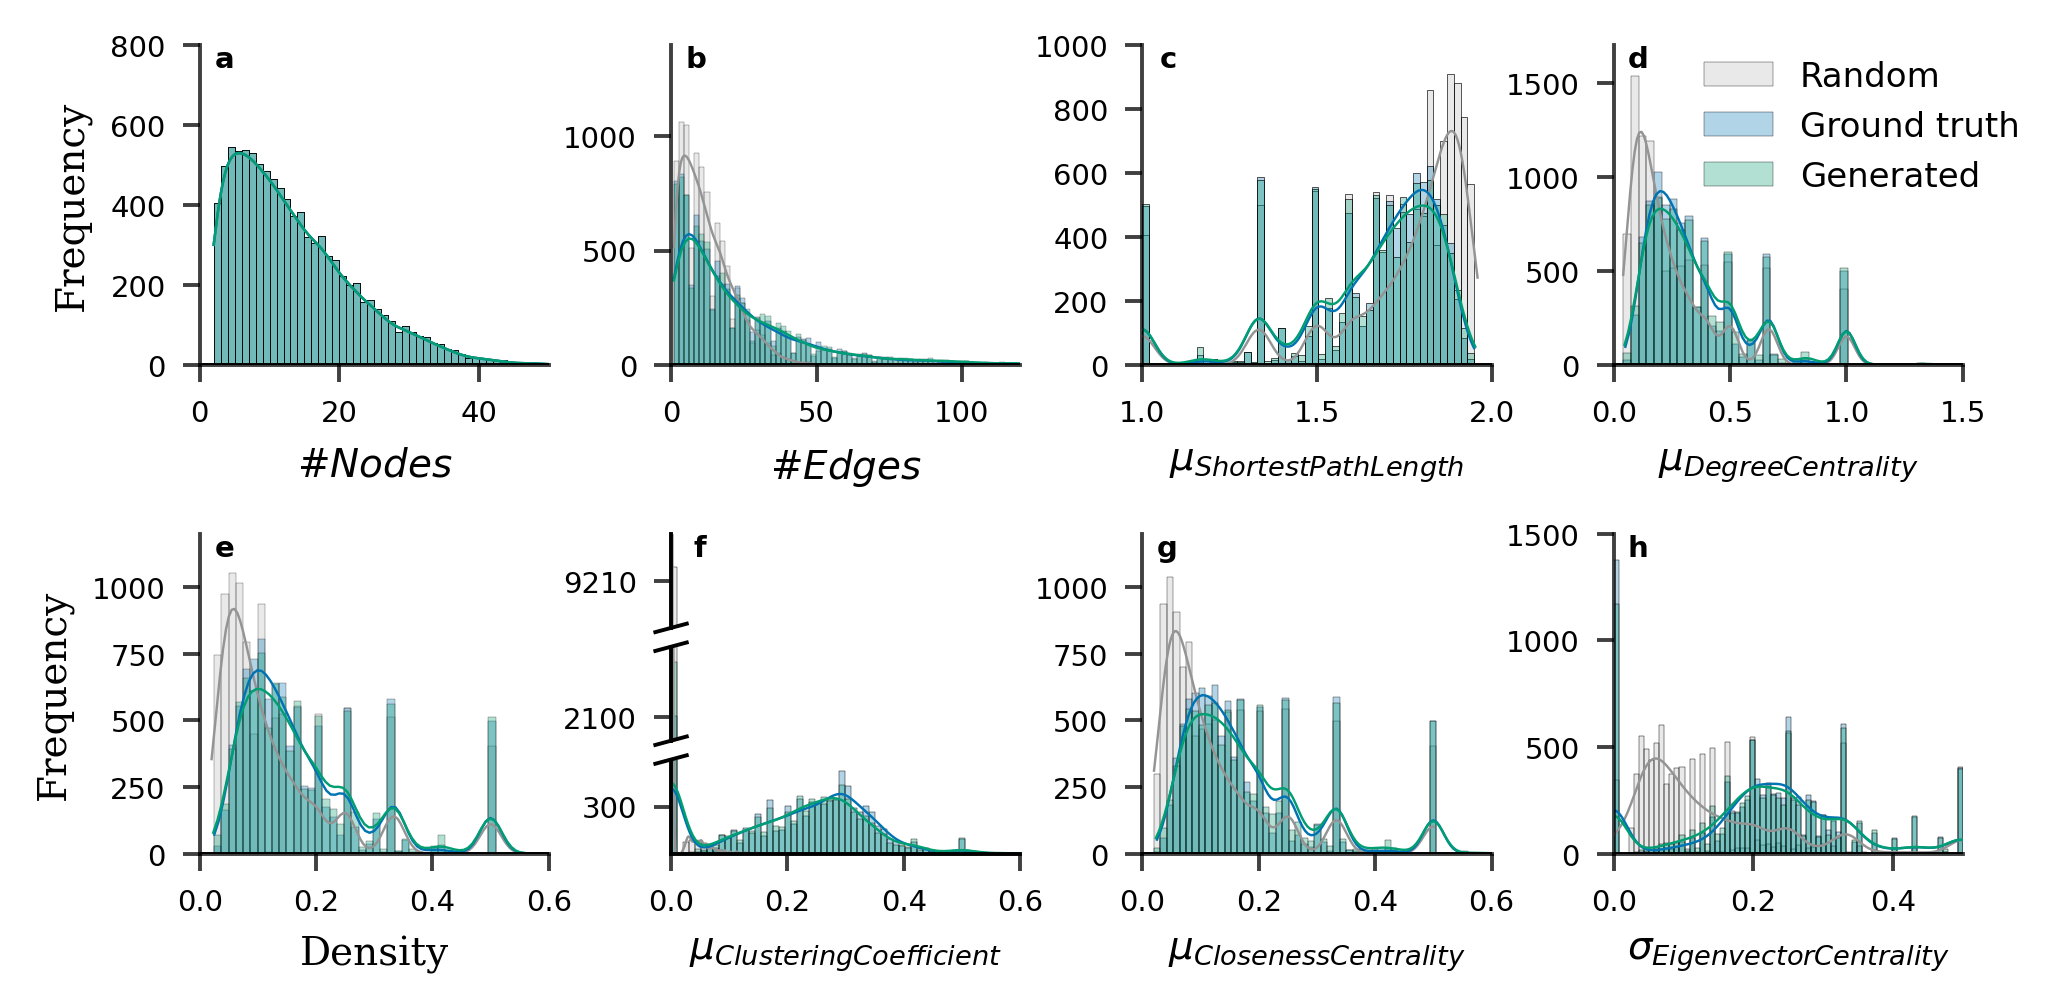

In [3]:
features_to_plot = [
    ("Number of Nodes", 
     df_merged['number_of_nodes_actual'], 
     df_merged['number_of_nodes_gpt'], 
     df_merged['number_of_nodes'], 
     np.linspace(df_merged['number_of_nodes_actual'].min(), df_merged['number_of_nodes_actual'].max(), 50)),
    ("Number of Edges", 
     df_merged['number_of_edges_actual'], 
     df_merged['number_of_edges_gpt'], 
     df_merged['number_of_edges'], 
     np.linspace(df_merged['number_of_edges_actual'].min(), df_merged['number_of_edges_actual'].max(), 120)),
    ("Average Shortest Path Length", 
     df_merged['average_shortest_path_length_actual'], 
     df_merged['average_shortest_path_length_gpt'], 
     df_merged['average_shortest_path_length'], 
     np.linspace(df_merged['average_shortest_path_length_actual'].min(), df_merged['average_shortest_path_length_actual'].max(), 50)),
    ("Density", 
     df_merged['density_actual'], 
     df_merged['density_gpt'], 
     df_merged['density'], 
     np.linspace(df_merged['density_actual'].min(), df_merged['density_actual'].max(), 120)),
    ("Average Clustering Coefficient", 
     df_merged['average_clustering_actual'], 
     df_merged['average_clustering_gpt'], 
     df_merged['average_clustering'], 
     np.linspace(df_merged['average_clustering_actual'].min(), df_merged['average_clustering_actual'].max(), 70)),
    ("Mean Degree Centrality", 
     df_features[df_features['graph_type'] == 'Actual']['Mean Degree Centrality'], 
     df_features[df_features['graph_type'] == 'GPT']['Mean Degree Centrality'], 
     df_features[df_features['graph_type'] == 'Random']['Mean Degree Centrality'], 
     np.linspace(df_features['Mean Degree Centrality'].min(), df_features['Mean Degree Centrality'].max(), 90)),
    ("Mean Closeness Centrality", 
     df_features[df_features['graph_type'] == 'Actual']['Mean Closeness Centrality'], 
     df_features[df_features['graph_type'] == 'GPT']['Mean Closeness Centrality'], 
     df_features[df_features['graph_type'] == 'Random']['Mean Closeness Centrality'], 
     np.linspace(df_features['Mean Closeness Centrality'].min(), df_features['Mean Closeness Centrality'].max(), 90)),
    ("STD Eigenvector Centrality", 
     df_features[df_features['graph_type'] == 'Actual']['STD Eigenvector Centrality'], 
     df_features[df_features['graph_type'] == 'GPT']['STD Eigenvector Centrality'], 
     df_features[df_features['graph_type'] == 'Random']['STD Eigenvector Centrality'], 
     np.linspace(df_features['STD Eigenvector Centrality'].min(), df_features['STD Eigenvector Centrality'].max(), 70)),
]

# Define title mapping
title_map = {
    'Number of Nodes': r'$\# Nodes$',
    'Number of Edges': r'$\# Edges$',
    'Average Shortest Path Length': r'$\mu_{Shortest Path Length}$',
    'Density': 'Density',
    'Average Clustering Coefficient': r'$\mu_{Clustering Coefficient}$',
    'Mean Degree Centrality': r'$\mu_{Degree Centrality}$',
    'Mean Closeness Centrality': r'$\mu_{Closeness Centrality}$',
    'STD Eigenvector Centrality': r'$\sigma_{Eigenvector Centrality}$'
}

# Define subplot structure
Figure1, ax1 = plt.subplot_mosaic(
    [
        ['A', 'B', 'C', 'F'],
        ['A', 'B', 'C', 'F'],
        ['A', 'B', 'C', 'F'],
        ['A', 'B', 'C', 'F'],
        ['A', 'B', 'C', 'F'],
        ['.', '.', '.', '.'],
        ['D', 'E1', 'G', 'H'],
        ['D', '.', 'G', 'H'],
        ['D', 'E3', 'G', 'H'],
        ['D', '.', 'G', 'H'],
        ['D', 'E2', 'G', 'H'],
    ],
    figsize=(6.5, 3),  
    dpi=350,
    gridspec_kw={'wspace': 0.35, 'hspace': 0.0,'height_ratios': [0.5,0.1 ,0.5,0.1,0.5, 0.9, 0.5,0.1, 0.5,0.1,0.5]}
)

# Map subplot labels
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

label_font = {'fontsize': 8, 'fontfamily': 'serif'}
title_font = {'fontsize': 12, 'fontfamily': 'serif'}
legend_font = {'fontsize': 6, 'fontfamily': 'serif'}
# Define custom limits for each subplot (adjust values as needed)
custom_limits = {
    'A': {'xlim': (0, 50), 'ylim': (0, 800)},
    'B': {'xlim': (0, 120), 'ylim': (0, 1400)},
    'C': {'xlim': (1.0, 2.0), 'ylim': (0, 1000)},
    'D': {'xlim': (0, 0.6), 'ylim': (0, 1200)},
    'E': {'xlim': (0, 0.6), 'ylim': (0, 1200)},
    'F': {'xlim': (0, 1.5), 'ylim': (0, 1700)},
    'G': {'xlim': (0, 0.6), 'ylim': (0, 1200)},
    'H': {'xlim': (0, 0.5), 'ylim': (0, 1500)}
}
subplot_labelling = ['a', 'b', 'c', 'e', 'f', 'd', 'g', 'h']
for i, (title, actual_data, gpt_data, random_data, bins) in enumerate(features_to_plot):
    if i !=4:  
        sns.histplot(random_data, color='#949494', label='Random', bins=bins, kde=True, alpha=0.2, ax=ax1[subplot_labels[i]], line_kws={'linewidth': 0.5})
        sns.histplot(actual_data, color='#0173B2', label='Ground truth', bins=bins, kde=True, alpha=0.3, ax=ax1[subplot_labels[i]], line_kws={'linewidth': 0.5})
        sns.histplot(gpt_data, color='#029E73', label='Generated', bins=bins, kde=True, alpha=0.3, ax=ax1[subplot_labels[i]], line_kws={'linewidth': 0.5})

        
        # Set custom x and y limits
        ax1[subplot_labels[i]].set_xlim(custom_limits[subplot_labels[i]]['xlim'])
        ax1[subplot_labels[i]].set_ylim(custom_limits[subplot_labels[i]]['ylim'])

        ax1[subplot_labels[i]].set_xlabel(title_map[title], fontdict=label_font)
        
        # **Remove y-labels for all except 'A' and 'D'**
        if subplot_labels[i] in ['A', 'D']:
            ax1[subplot_labels[i]].set_ylabel('Frequency', fontdict=label_font)
        else:
            ax1[subplot_labels[i]].set_ylabel('')

        ax1[subplot_labels[i]].spines['top'].set_visible(False)
        ax1[subplot_labels[i]].spines['right'].set_visible(False)
        ax1[subplot_labels[i]].spines['left'].set_visible(True)
        ax1[subplot_labels[i]].spines['left'].set_alpha(0.75)
        ax1[subplot_labels[i]].spines['bottom'].set_visible(True)
        ax1[subplot_labels[i]].spines['bottom'].set_alpha(0.75)

        ax1[subplot_labels[i]].axhline(0, color='black', linewidth=1)
        ax1[subplot_labels[i]].tick_params(axis='both', which='major', labelsize=6, color=[0, 0, 0, 0.75])

        # Legend only in subplot 'F'
        if subplot_labels[i] == 'F':
            leg = ax1[subplot_labels[i]].legend(fontsize=7, title_fontsize=10, facecolor='white', bbox_to_anchor=(1.25, 1.05), loc='upper right',frameon=False)
            #leg.get_frame().set_linewidth(0.)
        else:
            if ax1[subplot_labels[i]].get_legend() is not None:
                ax1[subplot_labels[i]].get_legend().remove()
        ax1[subplot_labels[i]].text(0.1, 1.0, subplot_labelling[i], transform=ax1[subplot_labels[i]].transAxes, fontsize=6, fontweight='bold', va='top', ha='right')
    else:
        sns.histplot(random_data, color='#949494', label='Random', bins=bins, kde=True, alpha=0.2, ax=ax1['E1'], line_kws={'linewidth': 0.5})
        sns.histplot(random_data, color='#949494', label='Random', bins=bins, kde=True, alpha=0.2, ax=ax1['E2'], line_kws={'linewidth': 0.5})
        sns.histplot(random_data, color='#949494', label='Random', bins=bins, kde=True, alpha=0.2, ax=ax1['E3'], line_kws={'linewidth': 0.5})
        sns.histplot(actual_data, color="#0173B2", label='Ground truth', bins=bins, kde=True, alpha=0.3, ax=ax1['E1'], line_kws={'linewidth': 0.5})
        sns.histplot(actual_data, color="#0173B2", label='Ground truth', bins=bins, kde=True, alpha=0.3, ax=ax1['E2'], line_kws={'linewidth': 0.5})
        sns.histplot(actual_data, color="#0173B2", label='Ground truth', bins=bins, kde=True, alpha=0.3, ax=ax1['E3'], line_kws={'linewidth': 0.5})
        sns.histplot(gpt_data, color='#029E73', label='Generated', bins=bins, kde=True, alpha=0.3, ax=ax1['E1'], line_kws={'linewidth': 0.5})
        sns.histplot(gpt_data, color='#029E73', label='Generated', bins=bins, kde=True, alpha=0.3, ax=ax1['E2'], line_kws={'linewidth': 0.5})
        sns.histplot(gpt_data, color='#029E73', label='Generated', bins=bins, kde=True, alpha=0.3, ax=ax1['E3'], line_kws={'linewidth': 0.5})

        ax1['E1'].spines['top'].set_visible(False)
        ax1['E1'].spines['bottom'].set_visible(False)
        ax1['E1'].spines['right'].set_visible(False)

        ax1['E2'].spines['right'].set_visible(False)
        ax1['E2'].spines['top'].set_visible(False)

        ax1['E3'].spines['top'].set_visible(False)
        ax1['E3'].spines['bottom'].set_visible(False)
        ax1['E3'].spines['right'].set_visible(False)

        for j in [1,3]:

            ax1[f'E{j}'].sharex(ax1['E2'])
            ax1[f'E{j}'].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            ax1[f'E{j}'].tick_params(axis='y', which='major', labelsize=6, color=[0, 0, 0, 0.75])
            
            
            ax1[f'E{j}'].set_xlabel("")
            ax1[f'E{j}'].set_ylabel("")

        ax1['E2'].set_ylabel("")

        ax1['E2'].set_xlabel(title_map[title], fontdict=label_font)
        ax1['E2'].tick_params(axis='both', which='major', labelsize=6, color=[0, 0, 0, 0.75])
        
        #ax1['E2'].set_xlim(custom_limits['E']['xlim'])
        ax1['E2'].set_ylim(0,600)
        ax1['E2'].set_yticks([300])
        ax1['E2'].set_xlim(0, 0.6)

        ax1['E3'].set_ylim(2000,2400)
        ax1['E3'].set_yticks([2100])
        ax1['E1'].set_ylim(9200,9220)
        ax1['E1'].set_yticks([9210])

        d = .045  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax1["E1"].transAxes, color='k', clip_on=False, linewidth=0.8)
        ax1["E1"].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

        kwargs.update(transform=ax1["E3"].transAxes)  # switch to the bottom axes
        ax1["E3"].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        kwargs.update(transform=ax1["E3"].transAxes)  # switch to the bottom axes
        ax1["E3"].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

        kwargs.update(transform=ax1["E2"].transAxes)  # switch to the bottom axes
        ax1["E2"].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    
        ax1['E1'].text(0.1, 1.0, 'f', transform=ax1['E1'].transAxes, fontsize=6, fontweight='bold', va='top', ha='right')